# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

from wordcloud import WordCloud
from IPython.display import Image

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Dataset

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/GoEmotions/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv("/content/drive/MyDrive/GoEmotions/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_test = pd.read_csv("/content/drive/MyDrive/GoEmotions/data/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [ ]:
df = pd.concat([df_train, df_dev, df_test])

In [ ]:
df.head()

,Text,Class,ID
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [ ]:
df.describe()

,Text,Class,ID
count,54263,54263,54263
unique,53994,782,54263
top,Thank you.,27,eebbqej
freq,15,16021,1


In [ ]:
# Count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


## Data Processing

In [ ]:
df['List of classes'] = df['Class'].apply(lambda x: x.split(','))

In [ ]:
df['Len of classes'] = df['List of classes'].apply(lambda x: len(x))

In [ ]:
df[df['Len of classes'] == 5]

,Text,Class,ID,List of classes,Len of classes
7873,Yeah I probably would've started crying on the...,"9,12,14,19,25",ee6lqiq,"[9, 12, 14, 19, 25]",5


In [ ]:
temp_df = df["Len of classes"].value_counts().sort_index()

trace1 = go.Bar(
                x = ['1','2','3','4','5'],
                y = temp_df.tolist(),
                marker = dict(color = 'rgb(250,13,92)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_df.tolist(), textposition='outside',
                width=[0.5, 0.5, 0.5, 0.5, 0.5])
layout = go.Layout(template= "plotly_dark",title = 'Number of classes' , xaxis = dict(title = 'Class Numbers'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

In [ ]:
# remove values with more than one class
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

df = filter_rows_by_values(df, "Len of classes", ["2","3","4","5"])

In [ ]:
emotions_map = {}

### How to remove emotion "neutral"??

In [ ]:
with open('/content/drive/MyDrive/GoEmotions/data/emotions.txt', 'r') as f:
    for i,emotion in enumerate(f):
        emotions_map[str(i)] = emotion.strip()

In [ ]:
emotions_map

{'0': 'admiration',
 '1': 'amusement',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '2': 'anger',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment'}

In [ ]:
for i in emotions_map:
    df[emotions_map[i]] = df['List of classes'].apply(lambda x: 1 if i in x else 0)

In [ ]:
temp_df = df.copy()
temp_df.drop(['Class', 'ID', 'List of classes', 'Len of classes'], axis=1, inplace =True)

In [ ]:
emotion_list = list(emotions_map.values())

In [ ]:
temp_list = temp_df.drop(['Text'], axis=1).sum(axis=0).tolist()
trace1 = go.Bar(
                x = emotion_list,
                y = temp_list,
                marker = dict(color = 'rgb(127, 16, 238)',
                              line=dict(color='rgb(0,0,0)',width=1.5)),
                text=temp_list, textposition='outside')
layout = go.Layout(template= "plotly_dark",title = 'NUMBER OF EMOTIONS' , xaxis = dict(title = 'Emotion'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

# Modeling

## One-hot encoding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

feature_column = "Text"
df = df[ df["Len of classes"] == 1]
df["Class"].value_counts()

vectorizer = TfidfVectorizer(max_features= 3000, analyzer='word', token_pattern=r'\S+')
experimental_feature = df[feature_column].to_list()
labels = df['Class'].to_list()
vectors = vectorizer.fit_transform(experimental_feature)
print(df[feature_column].head(), df.shape, sep="\n")
X_train, X_test, y_train, y_test = train_test_split(
    vectors, labels, test_size=0.33, random_state=42)

0    My favourite food is anything I didn't have to...
1    Now if he does off himself, everyone will thin...
2                       WHY THE FUCK IS BAYLESS ISOING
3                          To make her feel threatened
4                               Dirty Southern Wankers
Name: Text, dtype: object
(45446, 33)


In [ ]:
X_train.shape

(30448, 30000)

In [ ]:
X_train

<30448x9 sparse matrix of type '<class 'numpy.float64'>'
	with 57191 stored elements in Compressed Sparse Row format>

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
# Predict on the test set results
y_pred = model.predict(X_test)

# Check accuracy score 
from sklearn.metrics import accuracy_score
print(format(accuracy_score(y_test, y_pred)))

0.5256700893452461


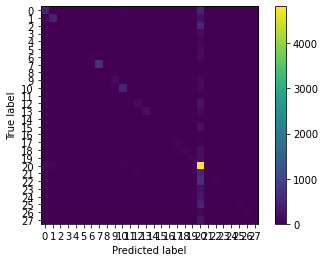

In [ ]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# print('Confusion matrix\n\n', cm)
ConfusionMatrixDisplay(cm).plot(include_values=False)

In [ ]:
pd.DataFrame(y_pred).value_counts()

27    10483
0       852
15      746
18      620
1       555
20      259
17      257
2       241
26      142
24      137
4       100
7        98
8        97
25       94
14       63
11       54
13       46
6        38
10       33
3        32
5        28
22        9
9         5
21        4
12        3
19        1
16        1
dtype: int64

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52      1119
           1       0.76      0.60      0.67       698
          10       0.30      0.02      0.03       619
          11       0.67      0.17      0.27       212
          12       0.33      0.02      0.03        66
          13       0.37      0.09      0.14       194
          14       0.65      0.22      0.33       183
          15       0.94      0.87      0.90       805
          16       0.00      0.00      0.00        15
          17       0.48      0.39      0.43       316
          18       0.72      0.77      0.74       579
          19       0.00      0.00      0.00        33
           2       0.56      0.32      0.40       424
          20       0.70      0.50      0.58       364
          21       0.25      0.04      0.06        28
          22       0.67      0.03      0.05       239
          23       0.00      0.00      0.00        30
          24       0.60    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Linear Support Vector Classifier

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train,y_train)

LinearSVC()

In [ ]:
clf.score(X_test,y_test)

0.5415388718495799

In [ ]:
predictions = clf.predict(X_test)
pd.DataFrame(predictions).value_counts()

27    8386
0     1070
15     760
1      669
18     602
4      377
7      335
2      305
20     282
10     266
17     260
26     226
3      214
25     201
24     156
14     139
5      126
6      126
11     116
8      104
9       87
22      77
13      66
12      29
23       8
19       8
21       3
dtype: int64

In [ ]:
df["Class"].value_counts()

27    16021
0      3384
15     2378
4      2367
1      2046
3      1809
10     1809
18     1760
7      1729
2      1265
20     1087
6      1057
17     1052
25     1003
26      902
9       888
5       831
22      749
11      635
13      619
14      553
8       497
24      437
12      246
19      105
23      103
21       67
16       47
Name: Class, dtype: int64

## Naive Bayes Classifier

In [ ]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB

# X_train.todense()
# instantiate the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train.todense(), y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



GaussianNB()

In [ ]:
y_pred = gnb.predict(X_test.todense())

y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



array(['13', '24', '14', ..., '11', '11', '22'], dtype='<U2')

In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.0869


In [ ]:
# Compare the train-set and test-set accuracy
y_pred_train = gnb.predict(X_train)

y_pred_train

TypeError: ignored

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

In [ ]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

## BERT

### Configuring TPU's

For this version of Notebook we will be using TPU's as we have to built a BERT Model

In [ ]:
import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
!pip install bert-tensorflow

In [ ]:
!pip install transformers

In [ ]:
from tokenizers import BertWordPieceTokenizer

In [ ]:
import transformers
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
df = fast_encode( .content.astype(str), fast_tokenizer, maxlen=MAX_LEN)